<a href="https://colab.research.google.com/github/epignatelli/fenton_karma_jax/blob/master/fenton_karma_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab runtime set to TPU accel
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.19.59.90:8470


In [2]:
!git clone https://github.com/epignatelli/fenton_karma_jax.git

Cloning into 'fenton_karma_jax'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 60 (delta 29), reused 14 (delta 5), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [0]:
import fenton_karma_jax.params as params
import fenton_karma_jax.model as model
import matplotlib.pyplot as plt
import jax
import jax.numpy as np

In [0]:
# geometry
shape = (128, 128)
dt = 0.1

# diffusivity map
d = 0.05
D = np.ones(shape) * d

# stimuli
field = np.zeros(shape)
field = jax.ops.index_update(field, jax.ops.index[0:20], .8)
s1 = {
    "field": field,
    "start": 0,
    "duration": 2,
    "period": 0  # non-cyclic
}

field2 = np.zeros(shape)
field2 = jax.ops.index_update(field, jax.ops.index[:, -20:], .5)
s2 = {
    "field": field2,
    "start": 200,
    "duration": 2,
    "period": 0  # non-cyclic
}

field3 = np.zeros(shape)
field2 = jax.ops.index_update(field, jax.ops.index[40:60], .5)
s3 = {
    "field": field3,
    "start": 360,
    "duration": 15,
    "period": 0  # non-cyclic
}

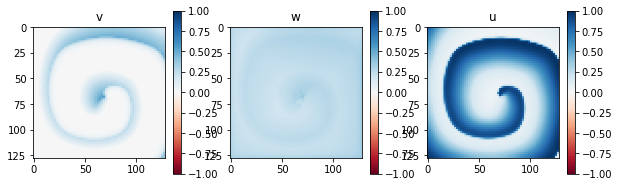

CPU times: user 2.48 s, sys: 2.79 s, total: 5.27 s
Wall time: 8.46 s


In [5]:
%%time
state = model.forward(shape, 100000, params.params_test(), D, [s1, s2], dt)
model.show(state, vmin=-1, vmax=1, cmap="RdBu")